In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [123]:
# параметры распределений
mu0, sigma0 = -2., 1.
mu1, sigma1 = 3., 2.

In [124]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [125]:
d0 = torch.distributions.Normal(torch.tensor([mu0, mu0]), torch.tensor([sigma0, sigma0]))
d1 = torch.distributions.Normal(torch.tensor([mu1, mu1]), torch.tensor([sigma1, sigma1]))

In [126]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([-0.1710,  0.1296]), tensor(0.4856)]


In [127]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 0.786792
Ошибка после 1 итераций: 0.256707
Ошибка после 2 итераций: 0.163209
Ошибка после 3 итераций: 0.124990
Ошибка после 4 итераций: 0.103645
Ошибка после 5 итераций: 0.090301
Ошибка после 6 итераций: 0.080594
Ошибка после 7 итераций: 0.074179
Ошибка после 8 итераций: 0.068803
Ошибка после 9 итераций: 0.065224
Ошибка после 10 итераций: 0.061035
Ошибка после 11 итераций: 0.058703
Ошибка после 12 итераций: 0.056053
Ошибка после 13 итераций: 0.054133
Ошибка после 14 итераций: 0.052502
Ошибка после 15 итераций: 0.050686
Ошибка после 16 итераций: 0.048984
Ошибка после 17 итераций: 0.048390
Ошибка после 18 итераций: 0.047093
Ошибка после 19 итераций: 0.046323


In [128]:
coord, label = sample(d0, d1, 100000)
x = coord.numpy()[:,0]
y = coord.numpy()[:,1]

# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10

xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

print(xmin, xmax, ymin, ymax)# Create meshgrid

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

-7.946102809906006 13.184797477722167 -8.317832565307617 13.965949630737304


In [129]:
import scipy.stats as st

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

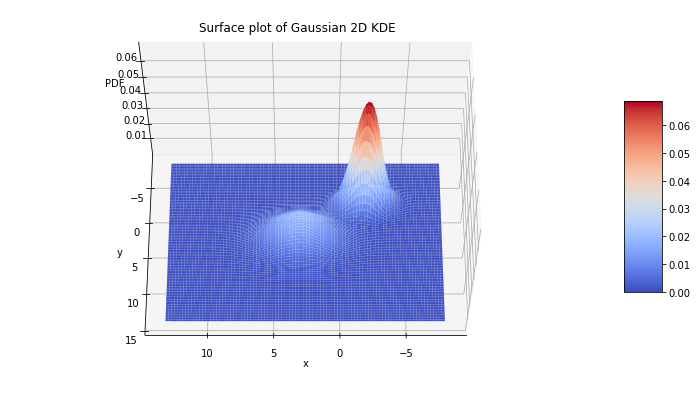

In [130]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 90)

In [7]:
x_scale = np.linspace(-10, 10, 5000)
d0_pdf = stats.norm.pdf(x_scale, mu0, sigma0) 
d1_pdf = stats.norm.pdf(x_scale, mu1, sigma1)
x_tensor = torch.tensor(x_scale.reshape(-1, 1), dtype=torch.float)
with torch.no_grad():
    dist = torch.sigmoid(layer(x_tensor)).numpy()
ratio = d1_pdf / (d1_pdf + d0_pdf)

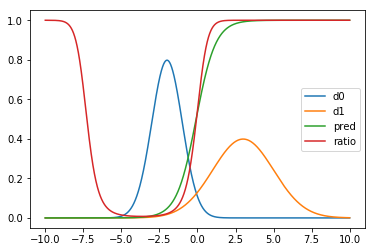

In [8]:
plt.plot(x_scale, d0_pdf*2, label='d0') # умножение на 2 для красоты графиков, на распределения не влияет
plt.plot(x_scale, d1_pdf*2, label='d1')
plt.plot(x_scale, dist.flatten(), label='pred')
plt.plot(x_scale, ratio, label='ratio')
plt.legend();

In [9]:
print([p.data[0] for p in layer.parameters()])

[tensor([1.5628]), tensor(0.1368)]


In [10]:
torch.log(F.sigmoid(torch.tensor(-100.)))

/home/atercygnus/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(-inf)

In [11]:
F.logsigmoid(torch.tensor(-100.))

tensor(-100.)